# Load dataset & preprocessing

In [1]:
import pandas as pd
import numpy as np

root_dir = "datasets/infuluenza/"
data_path = root_dir + "Influenza.csv"
exp_dir = "datasets/infuluenza/LSTM/"

df = pd.read_csv(data_path)

/home/is/daiki-ko/.local/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/home/is/daiki-ko/.local/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
df_tokyo = df[df['regnames'].isin(["Tokyo"])]

df_tokyo.head()

,Alltime,Time,region,regnames,Longitude,Latitude,Altitude,Year,Month,Week,Flucases,Holiday,Tempave,Tempmin,Tempmax,Rh
12480,12481,1,13,Tokyo,35.689185,139.691648,34.9,2000,1,1,818,2,9.528571,6.371429,13.385714,50.571429
12481,12482,2,13,Tokyo,35.689185,139.691648,34.9,2000,1,2,1167,3,8.642857,5.457143,12.000000,61.142857
12482,12483,3,13,Tokyo,35.689185,139.691648,34.9,2000,1,3,2562,2,6.828571,4.171429,9.500000,56.000000
12483,12484,4,13,Tokyo,35.689185,139.691648,34.9,2000,1,4,3781,2,5.342857,1.542857,9.400000,42.000000
12484,12485,5,13,Tokyo,35.689185,139.691648,34.9,2000,1,5,3903,2,7.214286,3.171429,11.585714,38.714286


In [3]:
train_n = int(len(df_tokyo["Flucases"])*0.75)
test_n = int(len(df_tokyo["Flucases"])*0.25)
train_n, test_n

(780, 260)

In [4]:
train_steps = np.arange(train_n)
test_steps = np.arange(train_n,train_n + test_n)

In [5]:
columns = ["Flucases","Tempave", "Rh", "Holiday"]

all_data = df_tokyo[columns]

In [6]:
train_df = all_data[columns][0:train_n]
test_df = all_data[columns][train_n:train_n+test_n]

In [7]:
train_df.head()

,Flucases,Tempave,Rh,Holiday
12480,818,9.528571,50.571429,2
12481,1167,8.642857,61.142857,3
12482,2562,6.828571,56.000000,2
12483,3781,5.342857,42.000000,2
12484,3903,7.214286,38.714286,2


In [8]:
test_df.head()

,Flucases,Tempave,Rh,Holiday
13260,3809,5.357143,47.142857,3
13261,9892,6.285714,38.285714,2
13262,8198,5.628571,53.857143,3
13263,9625,6.771429,63.714286,2
13264,7844,4.228571,49.000000,2


trainとtestのdfを作る

In [9]:
train_ts_df = train_df["Flucases"]
train_ys_df = train_df[["Tempave", "Rh"]]
train_xs_df = train_df["Holiday"]

test_ts_df = test_df["Flucases"]
test_ys_df = test_df[["Tempave", "Rh"]]
test_xs_df = test_df["Holiday"]

In [10]:
seq_length = 52

# Dataset and DataLoader

In [11]:
import os
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

import torch
import torch.nn as nn
from torch.nn import Sequential, Linear, Tanh, Sigmoid, LeakyReLU, ReLU
import torch.nn.functional as F
import torch.optim as optim

import numpy as np #数値計算用ライブラリ
import matplotlib.pyplot as plt #描画用ライブラリ

In [12]:
root_dir = "datasets/infuluenza/"
data_path = root_dir + "Influenza.csv"
data_dir = "datasets/infuluenza/vecLSTMx/"
exp_dir = "datasets/infuluenza/LSTM/"

In [13]:
import joblib

# スケーラーの読み込み
std_scaler = joblib.load(data_dir + 'std_scaler.joblib')

In [14]:
train_Xs = np.load(data_dir + "train_Xs_" + str(seq_length) + "w.npy")
train_ys = np.load(data_dir + "train_ys_" + str(seq_length) + "w.npy")
val_Xs = np.load(data_dir + "val_Xs_" + str(seq_length) + "w.npy")
val_ys = np.load(data_dir + "val_ys_" + str(seq_length) + "w.npy")

In [15]:
trn_xs_tensor = torch.Tensor(train_Xs[:,:,0:1])
trn_ys_tensor = torch.Tensor(train_ys[:,:,0:1])

val_xs_tensor = torch.Tensor(val_Xs[:,:,0:1])
val_ys_tensor = torch.Tensor(val_ys[:,:,0:1])

In [16]:
trn_xs_tensor.shape, trn_ys_tensor.shape, val_xs_tensor.shape, val_ys_tensor.shape

(torch.Size([582, 52, 1]),
 torch.Size([582, 1, 1]),
 torch.Size([146, 52, 1]),
 torch.Size([146, 1, 1]))

In [17]:
from torch.utils.data import TensorDataset, DataLoader

trn_dataset = TensorDataset(trn_xs_tensor, trn_ys_tensor)
trn_loader = DataLoader(dataset=trn_dataset,batch_size=50,shuffle=True)

val_dataset = TensorDataset(val_xs_tensor, val_ys_tensor)
val_loader = DataLoader(dataset=val_dataset,batch_size=50,shuffle=False)

In [18]:
for id, batch_data in enumerate(trn_loader):
    
    batch_x, batch_y = batch_data
    print(id, batch_x.shape, batch_y.shape)

0 torch.Size([50, 52, 1]) torch.Size([50, 1, 1])
1 torch.Size([50, 52, 1]) torch.Size([50, 1, 1])
2 torch.Size([50, 52, 1]) torch.Size([50, 1, 1])
3 torch.Size([50, 52, 1]) torch.Size([50, 1, 1])
4 torch.Size([50, 52, 1]) torch.Size([50, 1, 1])
5 torch.Size([50, 52, 1]) torch.Size([50, 1, 1])
6 torch.Size([50, 52, 1]) torch.Size([50, 1, 1])
7 torch.Size([50, 52, 1]) torch.Size([50, 1, 1])
8 torch.Size([50, 52, 1]) torch.Size([50, 1, 1])
9 torch.Size([50, 52, 1]) torch.Size([50, 1, 1])
10 torch.Size([50, 52, 1]) torch.Size([50, 1, 1])
11 torch.Size([32, 52, 1]) torch.Size([32, 1, 1])


In [19]:
for id, batch_data in enumerate(val_loader):
    
    batch_x, batch_y = batch_data
    print(id, batch_x.shape, batch_y.shape)

0 torch.Size([50, 52, 1]) torch.Size([50, 1, 1])
1 torch.Size([50, 52, 1]) torch.Size([50, 1, 1])
2 torch.Size([46, 52, 1]) torch.Size([46, 1, 1])


# LSTM model

In [20]:
class LSTM(nn.Module):
    def __init__(self, input_size = 1, hidden_size=32, output_size=1, num_layers = 2):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = num_layers
        
        self.relu = ReLU()
        self.lrelu = LeakyReLU(negative_slope=0.01)
        
        # input_sizeは入力する次元数
        self.lstm = nn.LSTM(input_size=self.input_size, num_layers=self.n_layers, hidden_size=self.hidden_size, dropout=0.2)
        
        self.fc1 = nn.Linear(self.hidden_size, self.hidden_size * 4)
        self.fc2 = nn.Linear(self.hidden_size * 4, self.output_size)


    def forward(self, x):
        last_outs, hidden = self.lstm(x) #(batch_size, seq_len, hidden)
        outs = last_outs[:, -1, :] #(batch_size, hidden)
 
        h = self.relu(self.fc1(outs))
        y = self.relu(self.fc2(h))

        return y

In [21]:
model = LSTM(input_size = 1, hidden_size = 16, output_size = 1, num_layers = 1)

/home/is/daiki-ko/.local/lib/python3.9/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


## Prediction

In [22]:
batch_0x = list(trn_loader)[0][0]

In [23]:
batch_0x.shape

torch.Size([50, 52, 1])

In [24]:
preds = model(batch_0x)

In [25]:
preds.shape

torch.Size([50, 1])

## Train

In [26]:
model.cuda()

LSTM(
  (relu): ReLU()
  (lrelu): LeakyReLU(negative_slope=0.01)
  (lstm): LSTM(1, 16, dropout=0.2)
  (fc1): Linear(in_features=16, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=1, bias=True)
)

In [27]:
criterion = nn.MSELoss(reduction='mean').cuda()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [28]:
def val_model(epoch):
    
    model.eval()
    
    sum_errors = 0
    
    for batch_data in val_loader:
       
        with torch.no_grad():
            
            if torch.cuda.is_available():
                inputs, trues = batch_data
                inputs, trues = inputs.cuda(), trues.cuda()

            preds = model(inputs)
            true_y = trues.reshape(preds.shape)
            loss = criterion(preds, true_y)
            
            sum_errors = sum_errors + loss.data.item()

            del loss
            torch.cuda.empty_cache()
            
    return sum_errors / len(val_loader)

In [29]:
train_loss_hist = []
val_loss_hist = []
best_loss = 1e10
n_epochs = 500

for epoch in range(n_epochs):
    
    model.train()
    train_loss = 0
    
    for batch_data in trn_loader:
        
        inputs, trues = batch_data
        inputs, trues = inputs.cuda(), trues.cuda()
        
        optimizer.zero_grad()
        
        preds = model(inputs)
        true_y = trues.reshape(preds.shape)
        loss = criterion(preds, true_y)
        
        loss.backward() #偏微分を計算
        
        train_loss += loss.item()

        #パラメータを更新する
        optimizer.step()
    
    val_loss = val_model(epoch)
    train_loss_hist.append(train_loss / len(trn_loader))
    val_loss_hist.append(val_loss)
    
    print("epoch: ", epoch, "Train loss: ", train_loss / len(trn_loader), "Val loss: ", val_loss)
    
    if val_loss < best_loss:
        save_model_path = exp_dir + "best_model_" + str(seq_length) + "w.pt"
        torch.save(model, save_model_path)
        best_loss = val_loss

epoch:  0 Train loss:  0.8098194350798925 Val loss:  1.0420372883478801
epoch:  1 Train loss:  0.7366690586010615 Val loss:  0.9889246424039205
epoch:  2 Train loss:  0.7180182884136835 Val loss:  0.9488072991371155
epoch:  3 Train loss:  0.6833161277075609 Val loss:  0.9031943480173746
epoch:  4 Train loss:  0.637014102190733 Val loss:  0.838772734006246
epoch:  5 Train loss:  0.5994704775512218 Val loss:  0.7547931869824728
epoch:  6 Train loss:  0.5117903525630633 Val loss:  0.6293222904205322
epoch:  7 Train loss:  0.41254182904958725 Val loss:  0.48235533634821576
epoch:  8 Train loss:  0.27871449493492645 Val loss:  0.33972102403640747
epoch:  9 Train loss:  0.18439906618247429 Val loss:  0.23287586371103922
epoch:  10 Train loss:  0.1361402003094554 Val loss:  0.17740549395481744
epoch:  11 Train loss:  0.10222751872303586 Val loss:  0.16082702577114105
epoch:  12 Train loss:  0.12171571825941403 Val loss:  0.15817072490851083
epoch:  13 Train loss:  0.1052180406016608 Val loss:

epoch:  111 Train loss:  0.09835861328368385 Val loss:  0.15675516674915949
epoch:  112 Train loss:  0.09528603466848533 Val loss:  0.14937074730793634
epoch:  113 Train loss:  0.10069509021316965 Val loss:  0.15104013433059058
epoch:  114 Train loss:  0.09936681032801668 Val loss:  0.14889998733997345
epoch:  115 Train loss:  0.09485150082036853 Val loss:  0.14810759822527567
epoch:  116 Train loss:  0.09560883371159434 Val loss:  0.15000422795613608
epoch:  117 Train loss:  0.09312544018030167 Val loss:  0.1510663703083992
epoch:  118 Train loss:  0.09756184524546067 Val loss:  0.14882247895002365
epoch:  119 Train loss:  0.09941314440220594 Val loss:  0.14936155577500662
epoch:  120 Train loss:  0.09488144051283598 Val loss:  0.14821839580933252
epoch:  121 Train loss:  0.09632555108206968 Val loss:  0.14938525607188544
epoch:  122 Train loss:  0.09940745619436105 Val loss:  0.15087337295214334
epoch:  123 Train loss:  0.098355774457256 Val loss:  0.15300486236810684
epoch:  124 Tra

epoch:  221 Train loss:  0.09476962018137176 Val loss:  0.15509408712387085
epoch:  222 Train loss:  0.09581835102289915 Val loss:  0.15138901273409525
epoch:  223 Train loss:  0.09823677393918236 Val loss:  0.15267227093378702
epoch:  224 Train loss:  0.09572468372061849 Val loss:  0.14936996499697366
epoch:  225 Train loss:  0.0966434720903635 Val loss:  0.1496958260734876
epoch:  226 Train loss:  0.09394900919869542 Val loss:  0.15157024562358856
epoch:  227 Train loss:  0.09383747501609226 Val loss:  0.15116261194149652
epoch:  228 Train loss:  0.09815203646818797 Val loss:  0.1509839122494062
epoch:  229 Train loss:  0.10015055444091558 Val loss:  0.15267937382062277
epoch:  230 Train loss:  0.09367192381372054 Val loss:  0.15050053348143896
epoch:  231 Train loss:  0.0993849579244852 Val loss:  0.1525565286477407
epoch:  232 Train loss:  0.09959973363826673 Val loss:  0.1493886187672615
epoch:  233 Train loss:  0.10164633641640346 Val loss:  0.15306569139162698
epoch:  234 Train 

epoch:  330 Train loss:  0.09726941616584857 Val loss:  0.14819551755984625
epoch:  331 Train loss:  0.09865567181259394 Val loss:  0.1503965655962626
epoch:  332 Train loss:  0.09515262418426573 Val loss:  0.1490768219033877
epoch:  333 Train loss:  0.09486149810254574 Val loss:  0.1491944541533788
epoch:  334 Train loss:  0.09398746816441417 Val loss:  0.15289676437775293
epoch:  335 Train loss:  0.09675236186012626 Val loss:  0.15031581868728003
epoch:  336 Train loss:  0.09779185770700376 Val loss:  0.15136082470417023
epoch:  337 Train loss:  0.0945679818590482 Val loss:  0.14850635826587677
epoch:  338 Train loss:  0.0966970279502372 Val loss:  0.15079155067602792
epoch:  339 Train loss:  0.0935594371209542 Val loss:  0.14882345497608185
epoch:  340 Train loss:  0.09469756220156948 Val loss:  0.14925780147314072
epoch:  341 Train loss:  0.09613504990314443 Val loss:  0.1552352507909139
epoch:  342 Train loss:  0.1027550717505316 Val loss:  0.15019896378119788
epoch:  343 Train lo

epoch:  439 Train loss:  0.09817765808353822 Val loss:  0.14992612848679224
epoch:  440 Train loss:  0.09821513683224718 Val loss:  0.15443256249030432
epoch:  441 Train loss:  0.09423233506580193 Val loss:  0.15063439309597015
epoch:  442 Train loss:  0.09293552775246401 Val loss:  0.15141154577334723
epoch:  443 Train loss:  0.10023385984823108 Val loss:  0.1493391916155815
epoch:  444 Train loss:  0.09419349759506683 Val loss:  0.1500713105003039
epoch:  445 Train loss:  0.09494730411097407 Val loss:  0.15233231087525687
epoch:  446 Train loss:  0.09886733007927735 Val loss:  0.15058560421069464
epoch:  447 Train loss:  0.09514871084441741 Val loss:  0.14915478974580765
epoch:  448 Train loss:  0.09484280444060762 Val loss:  0.15223112950722376
epoch:  449 Train loss:  0.09573339810594916 Val loss:  0.1502287487188975
epoch:  450 Train loss:  0.09603399472932021 Val loss:  0.15568328648805618
epoch:  451 Train loss:  0.09427201220144828 Val loss:  0.14972251653671265
epoch:  452 Tra

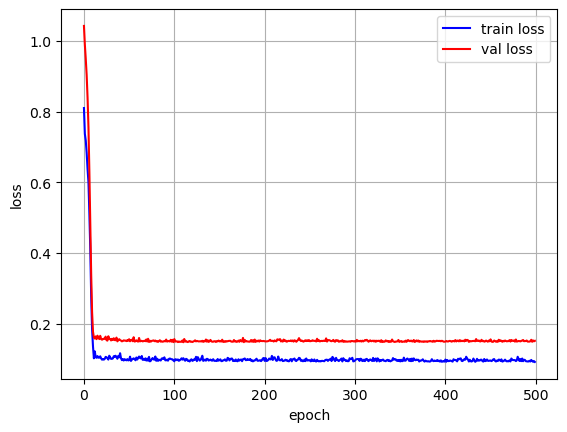

In [30]:
import matplotlib.pyplot as plt

plt.plot(range(len(train_loss_hist)), train_loss_hist, c='b', label='train loss')
plt.plot(range(len(val_loss_hist)), val_loss_hist, c='r', label='val loss')
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()
plt.grid()
plt.show()

In [31]:
np.argmin(val_loss_hist), np.min(val_loss_hist)

(110, 0.1476168856024742)

In [32]:
save_model_path = exp_dir + "best_model_" + str(seq_length) + "w.pt"

model = torch.load(save_model_path)

### Scatter plot

In [33]:
preds_list = []
trues_list = []

model.eval()
with torch.no_grad(): # 勾配計算の無効化
    for id, data in enumerate(trn_dataset):
        inputs, trues = data
        inputs, trues = inputs.cuda(), trues.cuda()

        inputs = torch.reshape(inputs, (1, seq_length, inputs.shape[-1]))
        preds = model(inputs)
        true_y = trues.reshape(preds.shape)
        
        print(id)
        preds_list.append(preds.to('cpu').detach().numpy().copy())
        trues_list.append(true_y.to('cpu').detach().numpy().copy())

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [34]:
np.array(trues_list).shape, np.array(preds_list).shape

((582, 1, 1), (582, 1, 1))

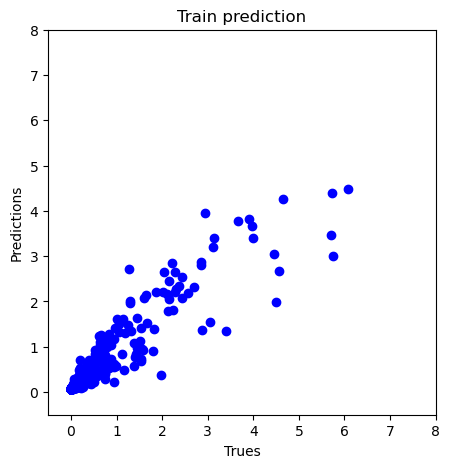

In [35]:
import matplotlib.pyplot as plt

plt.figure(figsize=(5,5))
plt.scatter(np.array(trues_list)[:,:,0], np.array(preds_list)[:,:,0], c = "b") # 散布図を描画
plt.title("Train prediction")
plt.xlabel("Trues")
plt.ylabel("Predictions")
# y=x の対角線を追加
#plt.plot([-2.0, 3.5], [-2.0, 3.5], 'r--')  # 赤の破線で対角線を描画

plt.xlim(-0.5, 8)
plt.ylim(-0.5, 8)

plt.show()

In [36]:
preds_list = []
trues_list = []

model.eval()
with torch.no_grad(): # 勾配計算の無効化
    for id, data in enumerate(val_dataset):
        inputs, trues = data
        inputs, trues = inputs.cuda(), trues.cuda()

        inputs = torch.reshape(inputs, (1, seq_length, inputs.shape[-1]))
        preds = model(inputs)
        true_y = trues.reshape(preds.shape)
        
        print(id)
        preds_list.append(preds.to('cpu').detach().numpy().copy())
        trues_list.append(true_y.to('cpu').detach().numpy().copy())

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145


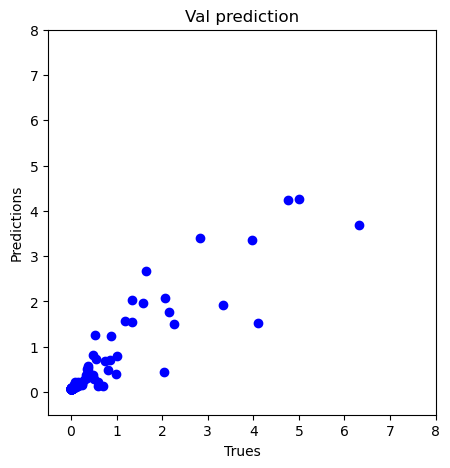

In [37]:
import matplotlib.pyplot as plt

plt.figure(figsize=(5,5))
plt.scatter(np.array(trues_list)[:,:,0], np.array(preds_list)[:,:,0], c = "b") # 散布図を描画
plt.title("Val prediction")
plt.xlabel("Trues")
plt.ylabel("Predictions")
# y=x の対角線を追加
#plt.plot([-2.0, 3.5], [-2.0, 3.5], 'r--')  # 赤の破線で対角線を描画

plt.xlim(-0.5, 8)
plt.ylim(-0.5, 8)

plt.show()

## Test prediction

In [38]:
#test_np = np.concatenate([test_ts_np.reshape(-1,1), test_ys_np, test_xs_np.reshape(-1,1)], axis = 1)

train_np = np.load(data_dir + "train_np.npy")
test_np = np.load(data_dir + "test_np.npy")

In [39]:
train_np.shape, test_np.shape

((780, 4), (260, 4))

In [40]:
#元のデータの最大値と最小値を指定
dat_min = 0
dat_max = 3e5

#スケール後の最大値と最小値を指定
custom_min = 0
custom_max = 100

test_scaled_ts = (np.array(test_np[:,0]) - dat_min) / (dat_max - dat_min) * (custom_max - custom_min) + custom_min

In [41]:
test_scaled_ys = std_scaler.transform(test_np[:,1:3])

/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [42]:
test_scaled_ys.shape, test_scaled_ts.reshape(-1,1).shape, test_np[:,-1].shape

((260, 2), (260, 1), (260,))

In [43]:
test_all_np = np.concatenate([test_scaled_ts.reshape(-1,1), test_scaled_ys, test_np[:,-1].reshape(-1,1)], axis = 1)

In [44]:
test_all_np.shape

(260, 4)

In [45]:
test_np[:,-1].shape, test_scaled_ts.shape, test_scaled_ys.shape, test_np.shape

((260,), (260,), (260, 2), (260, 4))

### 1. Prediction based on results from 40 days ago

In [46]:
from typing import Tuple

def make_sequence_data(data: np.ndarray, seq_size: int) -> Tuple[np.ndarray, np.ndarray]:
    
    """データをsequence_sizeに指定したサイズのシーケンスに分けてシーケンスとその答えをarrayで返す
    Args:
        data (np.ndarray): 入力データ
        seq_size (int): シーケンスサイズ
    Returns:
        seq_arr: seq_sizeに指定した数のシーケンスを格納するarray
        target_arr: シーケンスに対応する答えを格納するarray
    """

    num_data = len(data)
    seq_data = []
    target_data = []
    
    for i in range(num_data - seq_size):
        seq_data.append(data[i:i+seq_size])
        target_data.append(data[i+seq_size:i+seq_size+1])
        
    seq_arr = np.array(seq_data)
    target_arr = np.array(target_data)

    return seq_arr, target_arr

In [47]:
test_Xs, test_ys = make_sequence_data(test_all_np, seq_length)

In [48]:
test_Xs.shape, test_ys.shape

((208, 52, 4), (208, 1, 4))

In [49]:
tst_xs_tensor = torch.Tensor(test_Xs[:,:,0:1])
tst_ys_tensor = torch.Tensor(test_ys[:,:,0:1])

In [50]:
from torch.utils.data import TensorDataset, DataLoader

tst_dataset = TensorDataset(tst_xs_tensor, tst_ys_tensor)

In [51]:
preds_list = []
trues_list = []

model.eval()
with torch.no_grad(): # 勾配計算の無効化
    for id, data in enumerate(tst_dataset):
        inputs, trues = data
        inputs, trues = inputs.cuda(), trues.cuda()

        inputs = torch.reshape(inputs, (1, seq_length, inputs.shape[-1]))
        preds = model(inputs)
        true_y = trues.reshape(preds.shape)
        
        print(id)
        preds_list.append(preds.to('cpu').detach().numpy().copy())
        trues_list.append(true_y.to('cpu').detach().numpy().copy())

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207


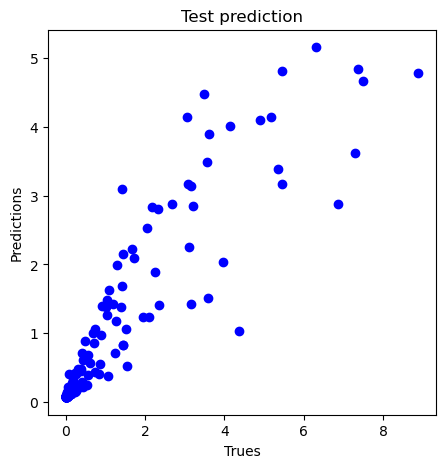

In [52]:
import matplotlib.pyplot as plt

plt.figure(figsize=(5,5))
plt.scatter(np.array(trues_list)[:,:,0], np.array(preds_list)[:,:,0], c = "b") # 散布図を描画
plt.title("Test prediction")
plt.xlabel("Trues")
plt.ylabel("Predictions")
# y=x の対角線を追加
#plt.plot([-2.0, 3.5], [-2.0, 3.5], 'r--')  # 赤の破線で対角線を描画

plt.show()

In [53]:
tst_trues, tst_preds = np.array(trues_list)[:,:,0], np.array(preds_list)[:,:,0]

In [54]:
tst_preds = (np.array(preds_list)[:,:,0] - custom_min) / (custom_max - custom_min) * (dat_max - dat_min) + dat_min

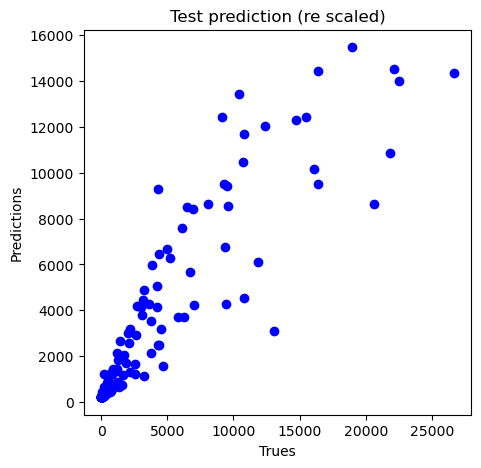

In [55]:
import matplotlib.pyplot as plt

plt.figure(figsize=(5,5))
plt.scatter(test_np[seq_length:,0], tst_preds, c = "b") # 散布図を描画
plt.title("Test prediction (re scaled)")
plt.xlabel("Trues")
plt.ylabel("Predictions")
# y=x の対角線を追加
#plt.plot([-2.0, 3.5], [-2.0, 3.5], 'r--')  # 赤の破線で対角線を描画

plt.show()

In [56]:
tst_preds.shape

(208, 1)

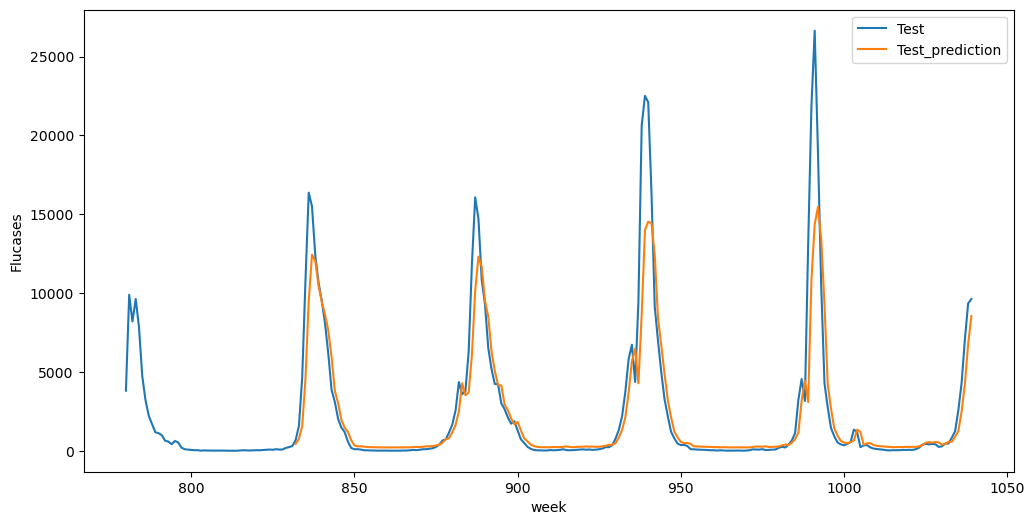

In [57]:
plt.figure(figsize=(12, 6))
plt.plot(test_steps, df_tokyo["Flucases"][train_n:train_n+test_n],label="Test")
plt.plot(test_steps[seq_length:], tst_preds,label="Test_prediction")

plt.xlabel("week")
plt.ylabel("Flucases")
plt.legend()

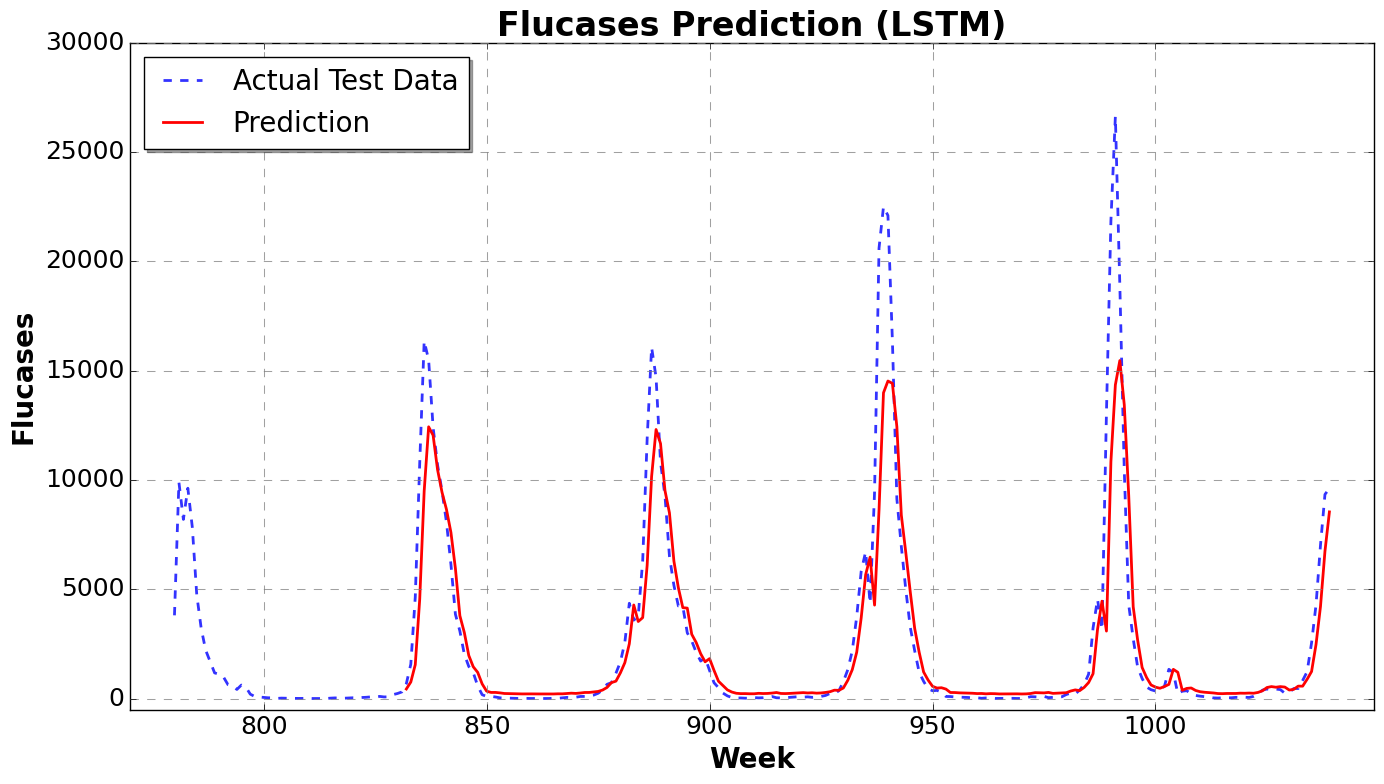

In [58]:
plt.figure(figsize=(14, 8))
plt.style.use('classic')  # スタイリッシュな背景に変更

# 実際のデータと予測データをプロット
plt.plot(test_steps, df_tokyo["Flucases"][train_n:train_n+test_n], label="Actual Test Data", linestyle='--', linewidth=2, color='blue', alpha=0.8)
plt.plot(test_steps[seq_length:], tst_preds, label="Prediction", linestyle='-', linewidth=2, color='red', alpha=1.0)

# 軸ラベルとタイトルを追加
plt.xlabel("Week", fontsize=20, fontweight='bold')
plt.ylabel("Flucases", fontsize=20, fontweight='bold')
plt.title("Flucases Prediction (LSTM)", fontsize=24, fontweight='bold')

# グリッドの調整
plt.grid(color='gray', linestyle='--', linewidth=0.75, alpha=0.75)

# 目盛りのフォントサイズを変更
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

# 凡例の調整
plt.legend(fontsize=20, loc='upper left', frameon=True, shadow=True)
plt.ylim(bottom=-500)
plt.xlim(left=min(test_steps) - 10, right = max(test_steps) + 10)

# 仕上げ
plt.tight_layout()
plt.show()

In [59]:
from sklearn.metrics import (
    mean_squared_error,  # MSE
    mean_absolute_error,  # MAE
    r2_score, # R2
)

from scipy.stats import pearsonr

def reg_metric(trues, preds, name):
    mse = mean_squared_error(trues, preds)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(trues, preds)
    r2 = r2_score(trues, preds)
    r, p = pearsonr(trues, preds)
    
    print(name)
    print(f'MSE : {mse}.')
    print(f'RMSE : {rmse}.')
    print(f'MAE : {mae}.')
    print(f'R2 : {r2}.')
    print("pearson :", r, p)

In [60]:
reg_metric(test_np[seq_length:,0], tst_preds[:,0], "Flucases")

Flucases
MSE : 4833819.934625349.
RMSE : 2198.5949910398117.
MAE : 963.4556115223811.
R2 : 0.7995370638979633.
pearson : 0.9151732687761033 3.0822988132000973e-83
